### Importing all the libraries needed.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.constraints import max_norm

### Read the rawdata.csv dataset using pandas read_csv().

In [2]:
dataset = pd.read_csv('rawdata.csv')
dataset.head()

,SAMPLE_ID,snp_0,snp_1,snp_2,snp_3,snp_4,snp_5,snp_6,snp_7,snp_8,snp_9,snp_10,snp_11,snp_12,snp_13,snp_14,snp_15,snp_16,snp_17,snp_18,snp_19,snp_20,snp_21,snp_22,snp_23,snp_24,snp_25,snp_26,snp_27,snp_28,snp_29,snp_30,snp_31,snp_32,snp_33,snp_34,snp_35,snp_36,snp_37,snp_38,...,snp_9962,snp_9963,snp_9964,snp_9965,snp_9966,snp_9967,snp_9968,snp_9969,snp_9970,snp_9971,snp_9972,snp_9973,snp_9974,snp_9975,snp_9976,snp_9977,snp_9978,snp_9979,snp_9980,snp_9981,snp_9982,snp_9983,snp_9984,snp_9985,snp_9986,snp_9987,snp_9988,snp_9989,snp_9990,snp_9991,snp_9992,snp_9993,snp_9994,snp_9995,snp_9996,snp_9997,snp_9998,snp_9999,snp_10000,STATUS
0,HCB181,1,0,0,1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,0,0,2,2,2,2,1,1,2,2,2,2,2,2,0,0,0,0,2,2,...,1,2,2,1,2,1,2,2,1,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,1,2,1,2,1,2,1
1,HCB182,1,0,0,1,1,2,2,1,2,2,2,1,2,1,2,2,2,2,2,0,0,2,2,2,2,2,2,1,1,1,2,0,0,0,0,0,0,2,2,...,1,2,2,1,2,1,2,2,1,2,2,2,2,2,2,1,2,2,2,1,2,1,2,2,2,2,2,2,2,1,1,1,2,2,2,1,2,2,2,2
2,HCB183,1,0,0,1,2,2,2,1,2,2,2,1,2,1,1,2,2,2,2,0,0,2,2,2,2,1,2,1,2,1,2,2,2,0,0,0,0,2,2,...,1,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,1,2,2,2,1,2,2,2,1,2,2
3,HCB184,1,0,0,1,1,2,2,1,2,2,2,1,1,2,2,2,2,2,2,0,0,2,2,2,2,1,1,2,2,2,2,2,2,0,0,0,0,2,2,...,1,1,1,1,2,1,2,1,1,2,2,1,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,1,2,2,2,1,2,2
4,HCB185,1,0,0,1,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,1,2,...,1,1,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,1,2,2,2,2,2,1,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,1


### Filling values for X and y where X are the features and y is the status.

In [3]:
X = dataset.drop(['STATUS', 'SAMPLE_ID'], axis=1)
y = dataset[['STATUS']]
X, y

(    snp_0  snp_1  snp_2  snp_3  ...  snp_9997  snp_9998  snp_9999  snp_10000
 0       1      0      0      1  ...         1         2         1          2
 1       1      0      0      1  ...         1         2         2          2
 2       1      0      0      1  ...         2         2         1          2
 3       1      0      0      1  ...         2         2         1          2
 4       1      0      0      1  ...         2         2         2          2
 ..    ...    ...    ...    ...  ...       ...       ...       ...        ...
 84      1      0      0      1  ...         2         2         1          1
 85      1      0      0      1  ...         2         2         1          2
 86      1      0      0      1  ...         1         1         2          2
 87      1      0      0      1  ...         1         2         1          1
 88      1      0      0      1  ...         1         2         2          2
 
 [89 rows x 10001 columns],     STATUS
 0        1
 1        2

### Splitting the dataset into training and testing (80 20 respectively).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [5]:
print('Training Data Shape: ', X_train.shape, y_train.shape)
print('Testing Data Shape: ', X_test.shape, y_test.shape)

Training Data Shape:  (71, 10001) (71, 1)
Testing Data Shape:  (18, 10001) (18, 1)


### Checking the number of unique classes in the dataset. Here we can see there are a total of 2 unique classes, each having their own identity.

In [6]:
uniqueClasses = np.unique(y_train)
totalClasses = len(uniqueClasses)
print('Number of Unique Classes: ', totalClasses)
print('Classes: ', uniqueClasses)

Number of Unique Classes:  2
Classes:  [1 2]


### PCA using 95% variance.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(0.95) # 95% Variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print('Training Data Shape: ', X_train_pca.shape, y_train.shape)
print('Testing Data Shape: ', X_test_pca.shape, y_test.shape)

Training Data Shape:  (71, 65) (71, 1)
Testing Data Shape:  (18, 65) (18, 1)


### Right now the dataset is in the format of int8 so we have to convert it to float32 before feeding it into the model.

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

### Next, we are going to one hot encode the y_train and y_test using the to_categorical function.

In [9]:
y_train = y_train - 1
y_test = y_test - 1

y_train_encoded = to_categorical(y_train, num_classes = 2)
y_test_encoded = to_categorical(y_test, num_classes = 2)

# Test Print
y_test_encoded

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Reshaping the dataset so it could be feeded into Conv1D layers.

In [10]:
X_train_pca = X_train_pca.reshape(-1, 65, 1)
X_test_pca = X_test_pca.reshape(-1, 65, 1)

In [11]:
X_train_pca.shape, X_test_pca.shape

((71, 65, 1), (18, 65, 1))

### Now, we are going to split the training dataset into training and validation dataset. I have divided train and validation into 80 20 respectively.

In [12]:
X_train_pca, X_valid, train_label, valid_label = train_test_split(X_train_pca, y_train_encoded, test_size=0.2, random_state=13)

In [13]:
X_train_pca.shape, X_valid.shape, train_label.shape, valid_label.shape

((56, 65, 1), (15, 65, 1), (56, 2), (15, 2))

### This will be the part where modelling the data starts. I have used the batch size of 64 and 20 epochs.

In [14]:
batch_size = 64
epochs = 20

### First we add our first convolutional layer using Conv1D. We are using Conv1D here because we are dealing with non-image dataset. Next we add the LeakyReLU because it's going to help the network learn non-linear decision boundary. Next would be the MaxPooling1D layer and then the last layer would be the Dense layer using the softmax function. After that would be the Dropout layer which helps us avoiding the problem of overfitting. 

In [15]:
dna_model = Sequential()
dna_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(65, 1), padding='same'))
dna_model.add(MaxPooling1D(2, padding='same'))
dna_model.add(Dropout(0.4))
dna_model.add(Flatten())
dna_model.add(Dense(32, activation='relu'))
dna_model.add(LeakyReLU(alpha=0.1))
dna_model.add(Dropout(0.3))
dna_model.add(Dense(2, activation='relu'))

### Now we are going to compile our model that we just made using Adam Optimizer as the optimizer and Categorical CrossEntropy as the loss function which is often used as a loss function for multi-class classification.

In [16]:
dna_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [17]:
dna_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 65, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2112)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                67616     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

### Now we fit the model.

In [18]:
dna_train = dna_model.fit(X_train_pca, train_label, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_valid, valid_label))

Epoch 1/20
1/1 [==============================] - 13s 13s/step - loss: 6.2180 - accuracy: 0.4286 - val_loss: 5.6011 - val_accuracy: 0.4000
Epoch 2/20
1/1 [==============================] - 0s 34ms/step - loss: 5.3107 - accuracy: 0.5357 - val_loss: 4.6715 - val_accuracy: 0.4000
Epoch 3/20
1/1 [==============================] - 0s 23ms/step - loss: 4.4523 - accuracy: 0.5893 - val_loss: 6.5343 - val_accuracy: 0.4000
Epoch 4/20
1/1 [==============================] - 0s 23ms/step - loss: 5.0677 - accuracy: 0.5179 - val_loss: 6.3168 - val_accuracy: 0.4000
Epoch 5/20
1/1 [==============================] - 0s 28ms/step - loss: 4.3526 - accuracy: 0.5893 - val_loss: 5.4771 - val_accuracy: 0.4000
Epoch 6/20
1/1 [==============================] - 0s 23ms/step - loss: 4.4900 - accuracy: 0.6071 - val_loss: 5.0996 - val_accuracy: 0.4667
Epoch 7/20
1/1 [==============================] - 0s 22ms/step - loss: 3.6247 - accuracy: 0.6786 - val_loss: 4.6835 - val_accuracy: 0.4667
Epoch 8/20
1/1 [===========

### We evaluate the model to see how our model works on the testing dataset. The results that I've got is quite bad. The total loss is 4.5002 and the accuracy of 0.4444.

In [19]:
evaluation = dna_model.evaluate(X_test_pca, y_test_encoded, verbose=1)

1/1 [==============================] - 0s 13ms/step - loss: 4.5002 - accuracy: 0.4444


In [20]:
print('Test Loss: ', evaluation[0])
print('Test Accuracy: ', evaluation[1])

Test Loss:  4.500186443328857
Test Accuracy:  0.4444444477558136


### Now let's plot the loss and accuracy plots for training and validation to see the results visually.


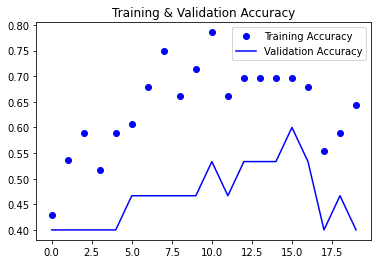

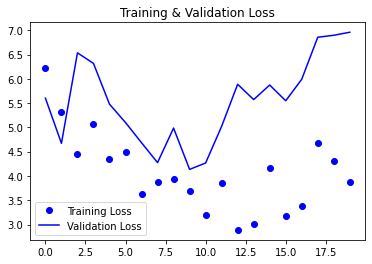

In [21]:
accuracy = dna_train.history['accuracy']
val_accuracy = dna_train.history['val_accuracy']
loss = dna_train.history['loss']
val_loss = dna_train.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

### Now we predict our model.

In [22]:
predicted = dna_model.predict(X_test_pca)
predicted = np.argmax(np.round(predicted), axis=1)

In [23]:
from sklearn.metrics import classification_report
class_number = ["Class {}".format(i) for i in range(2)]
print(classification_report(y_test, predicted, target_names=class_number))

              precision    recall  f1-score   support

     Class 0       0.56      1.00      0.71        10
     Class 1       0.00      0.00      0.00         8

    accuracy                           0.56        18
   macro avg       0.28      0.50      0.36        18
weighted avg       0.31      0.56      0.40        18



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
